In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random as rd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## Importing the dataset from a csv to a pandas dataframe

In [7]:
df = pd.read_csv('Metacog_PD.csv')
df

,MAS_S,MAS_O,MAS_D,MAS_M,PD
0,7.133423,4.997390,1.947515,5.675542,26
1,6.466554,4.858742,1.892814,7.933555,19
2,5.530974,6.218602,1.805891,6.523051,19
3,6.786667,6.205525,2.207397,5.722735,12
4,6.910360,4.638363,2.140847,6.114092,19
...,...,...,...,...,...
99994,7.889908,4.866328,1.576813,5.360657,45
99995,7.327724,5.487595,1.467832,6.380510,39
99996,7.535858,5.227088,1.839259,6.211535,45
99997,7.273975,4.697937,2.278434,5.404646,41


## Data Cleaning and Manipulalting
In this dataset missing data is recorded as 999, and will need to be removed. 

First, we replace all 999 values with an np.NaN values so that we can easily identify and remove
them with a sample pandas dropna function. 

Next, we create a metacog score column which is just the sum of all the individual MAS scores for
a single individual.

Data is then exported into a cleaned csv for further use.


In [8]:
df = df.replace(999, np.nan)

df.dropna(inplace=True)

df['METACOG'] = df['MAS_S'] + df['MAS_O'] + df['MAS_D'] + df['MAS_M']

df.to_csv('Metacog_PD_cleaned.csv')

## Creating an Elbow Plot for Cluster Identification



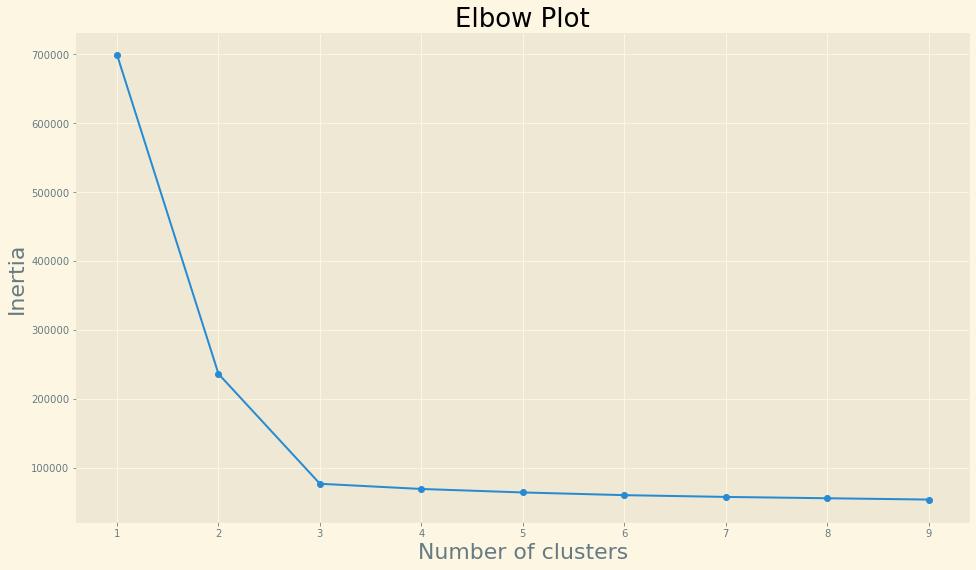

In [9]:
data=pd.read_csv("Metacog_PD_cleaned.csv")

#Standardize features by removing the mean and scaling to unit variance.
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

#Determining inertia values for 10 hypothetical clusters

SSE = []
for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, 
                    init = 'k-means++')
    kmeans.fit(data_scaled)
    SSE.append(kmeans.inertia_)

elbow_df = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(16,9))
plt.style.use('Solarize_Light2')
plt.plot(elbow_df['Cluster'], elbow_df['SSE'], marker='o')
plt.xlabel('Number of clusters', size = 22)
plt.ylabel('Inertia', size = 22)
plt.title('Elbow Plot', size = 26)
plt.show()

## K-Means Clustering 

Here we identify cluster centroids, and assign cluster status to indiviual data points 
based on distance to each centroid. 

Each cluster is coded by color, with centroids identified in red.

/var/folders/sh/86h8nww96zg4j028mg469_bh0000gn/T/ipykernel_51674/2547143090.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = ED
/var/folders/sh/86h8nww96zg4j028mg469_bh0000gn/T/ipykernel_51674/2547143090.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['Cluster'] = c


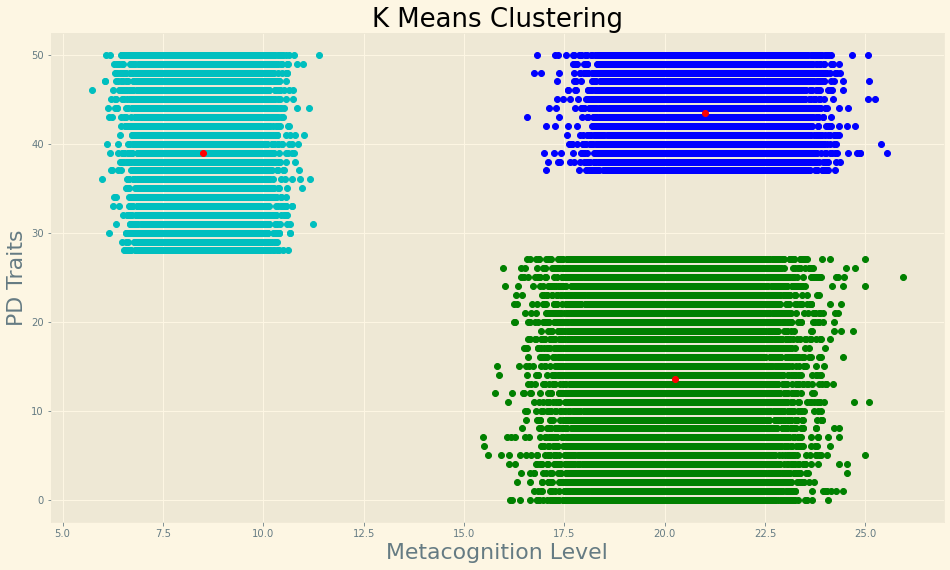

In [10]:
#Create a condensed df containing only our desired columns
x = data[['PD','METACOG']]
#k will be the number of clusters, as identified in the elbow plot above
k = 3 

#selects 'k' nubmer of points to act as centroids to clusters
centroids = (x.sample(n=k))

#This assigns all points to the closest centroid, recomputes centroids of new clusters, and repeats. 
#Change diff to a higher number for increased certainty at a trade-off of longer run time
plt.figure(figsize=(16,9))

diff = 100 
j = 0 
while diff != 0:
    xd = x 
    i = 1 
    for index1,row_c in centroids.iterrows():
        ED =[] 
        for index2,row_d in xd.iterrows():
            d1 = (row_c['METACOG']-row_d['METACOG'])**2
            d2 = (row_c['PD']-row_d['PD'])**2
            d = np.sqrt(d1+d2)
            ED.append(d)
        x[i] = ED
        i = i+1 
        
    c = []
    for index,row in x.iterrows():
        min_dist = row[1]
        pos = 1 
        for i in range(k):
            if row[i+1] < min_dist:
                min_dist = row[i+1]
                pos = i+1 
        c.append(pos)
    x['Cluster'] = c 
    centroids_new = x.groupby(['Cluster']).mean([['PD','METACOG']])
    if j == 0:
        diff = 100 
        j = j+1 
    else:
        diff = (centroids_new['PD'] - centroids['PD']).sum() + (centroids_new['METACOG'] - centroids['METACOG']).sum() 
    centroids = x.groupby(['Cluster']).mean()[['PD','METACOG']]
clist = ['c','g','b']
for k in range(k):
    data=x[x['Cluster']==k+1]
    plt.scatter(data['METACOG'],data['PD'],c=clist[k])
plt.scatter(centroids['METACOG'],centroids['PD'],c='r')
plt.title('K Means Clustering', size=26)
plt.xlabel('Metacognition Level', size=22)
plt.ylabel('PD Traits', size=22)
plt.show() 